In [1]:
import matplotlib.pyplot as plt
import torch
import os
from facenet_pytorch import InceptionResnetV1
from PIL import Image
from torchvision import transforms
from tqdm.notebook import tqdm
import numpy as np
from PIL import Image
from ultralytics import YOLO
import cv2
from glob import glob
from torch import Tensor
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
from moviepy.editor import concatenate_videoclips, VideoFileClip
import re


os.environ['HSA_OVERRIDE_GFX_VERSION'] = '10.3.0'
os.environ['HIP_VISIBLE_DEVICES'] = '0'

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Running on device: {device}")

Running on device: cuda


In [3]:
embedding_model = InceptionResnetV1(pretrained='vggface2').eval().to(device)
face_detection_model = YOLO("./yolov8l-face.pt").to(device)

In [4]:
transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
])

In [5]:
def get_faces(img: np.ndarray):
    with torch.no_grad():
        results = face_detection_model(img, verbose=False)
    
    faces = []
    boxes = results[0].boxes.xyxy.cpu()

    for box in boxes:
        x1, y1, x2, y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3])
        cropped = img[y1:y2, x1:x2, :]
        faces.append(cropped)
    return faces


def find_max_similarity(referece_img_embeddings: Tensor, targets: list, device):

    img_tensors = []
    for img in targets:
        img_tensor = transform(Image.fromarray(img))
        img_tensors.append(img_tensor)
    
    img_tensors = torch.stack(img_tensors, dim=0).to(device)

    with torch.no_grad():
        embedding = embedding_model(img_tensors)

    similarity = torch.cosine_similarity(referece_img_embeddings.unsqueeze(1), embedding, dim=-1)
    max_similarity = similarity.max()
    return max_similarity


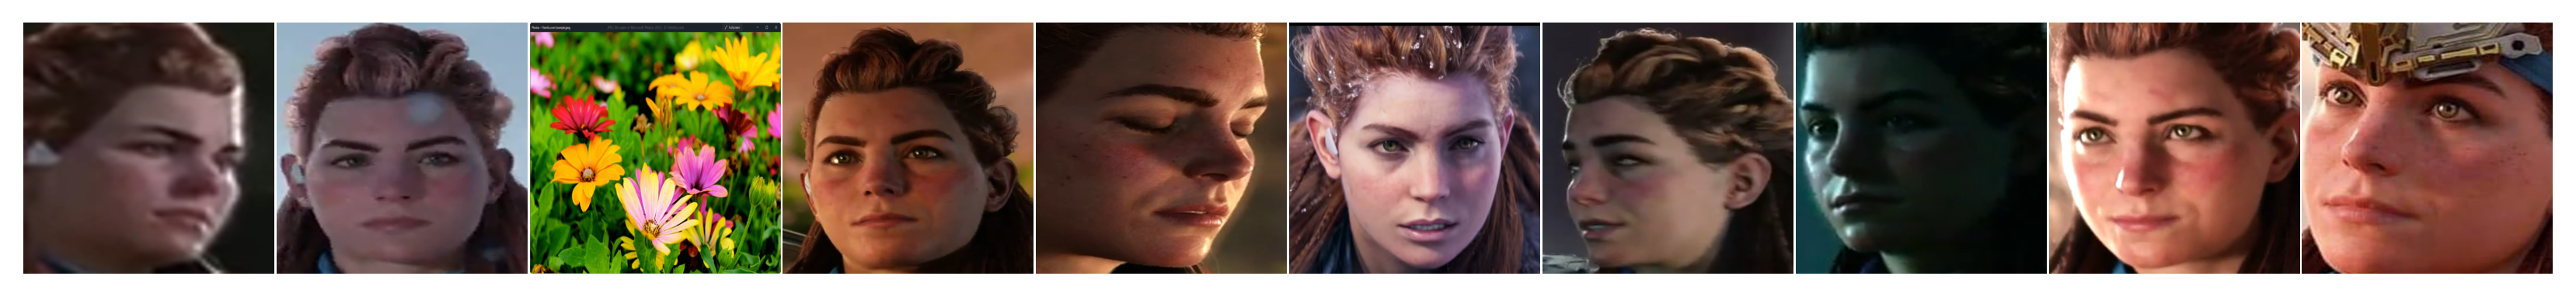

In [24]:
reference_imgs_dir = "./reference_images/"
img_filenames = glob("./reference_images/*.[pj][pn]g") + glob("./reference_images/*.jpeg")
fig, axs = plt.subplots(1, len(img_filenames), figsize=(14, 8), dpi=300)
reference_images = []

for img_filename, ax in zip(img_filenames, axs):
    source_face = Image.open(img_filename).convert('RGB').resize((800, 800))
    reference_images.append(transform(source_face))
    ax.imshow(source_face)
    ax.axis(False)

reference_images = torch.stack(reference_images, dim=0).to(device)
referece_img_embeddings = embedding_model(reference_images)

plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.show()

In [14]:
source_video = "./videoplayback1.mp4"
output_dir = "./output" 
video = cv2.VideoCapture(source_video)
frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
fps = round(video.get(cv2.CAP_PROP_FPS))
frame_count, fps

In [8]:
pbar = tqdm()
pbar.reset(total=frame_count)
similarity_threshold = 0.6

frame_intervals = []
prev_frame_cnt = -1
curr_frame_cnt = 0

while True:
    ret, frame = video.read()
    if not ret:
        break

    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    faces = get_faces(frame)

    if len(faces) > 0:
        similarity = find_max_similarity(referece_img_embeddings, faces, device=device)
        
        if similarity >= similarity_threshold:
            if curr_frame_cnt - prev_frame_cnt > 1:
                if len(frame_intervals) == 0:
                    frame_intervals.append([curr_frame_cnt, None])
                else:
                    frame_intervals[-1][-1] = prev_frame_cnt
                    frame_intervals.append([curr_frame_cnt, None])
                prev_frame_cnt = curr_frame_cnt
                
    curr_frame_cnt += 1
    pbar.update()

if len(frame_intervals) and frame_intervals[-1][-1] is None:
    frame_intervals[-1][-1] = prev_frame_cnt

0it [00:00, ?it/s]

In [9]:
video.release()

In [15]:
def get_clip_durations(frame_intervals: list, fps: int):
    clip_durations = []

    for interval in frame_intervals:
        start_time = interval[0] / fps
        end_time = interval[1] / fps
        clip_durations.append([start_time, end_time])

    return clip_durations


clip_intervals = get_clip_durations(frame_intervals, fps)

In [16]:
def merge_clips(clip_intervals: list, merge_threshold: float):
    processed_clip_durations = []

    for duration in clip_intervals:
        # if duration[-1] - duration[0] <= 1:
        #     continue
        if len(processed_clip_durations) == 0:
            processed_clip_durations.append(duration)
        else:
            if duration[0] - processed_clip_durations[-1][-1] <= merge_threshold:
                processed_clip_durations[-1][-1] = duration[1]
            else:
                processed_clip_durations.append(duration)

    return processed_clip_durations


merge_threshold = 2.5 # in seconds
processed_clip_intervals = merge_clips(clip_intervals, merge_threshold)
print(f'Number of clips: {len(processed_clip_intervals)}')

Number of clips: 28


In [18]:
def clip_video(clip_intervals: list, source_video: str, output_dir: str):
    try:
        _, source_video_ext = os.path.splitext(source_video)

        for i, (start, end) in enumerate(clip_intervals):
            output_video = os.path.join(output_dir, f"clip_{i+1}{source_video_ext}")
            ffmpeg_extract_subclip(filename=source_video, t1=start, t2=end, targetname=output_video)
    except Exception as e:
        print(f"Error: {e}")
    
    print("Cliping complete")


clip_video(processed_clip_intervals, source_video, output_dir)

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join

In [21]:
def fn(clipname):
    _, clip_ext = os.path.splitext(clipname)
    regx = f'clip_(\d+){clip_ext}'
    match = re.search(regx, os.path.basename(clipname))
    clip_number = int(match.group(1))
    return clip_number

video_filenames = glob(f'{output_dir}/*')
video_filenames = sorted(video_filenames, key=fn)
clips = [VideoFileClip(filename) for filename in video_filenames]

final_clip = concatenate_videoclips(clips)

_, ext = os.path.splitext(source_video)
final_clip.write_videofile(os.path.join(output_dir, f'merged{ext}'))

Moviepy - Building video ./output/merged.mp4.
Moviepy - Writing video ./output/merged.mp4



Moviepy - Done !
Moviepy - video ready ./output/merged.mp4


In [5]:
cwd = os.getcwd()
cwd

'/home/atiqur/Downloads/python-code/face-detection'